# 3-3,高阶API示范

In [1]:
import tensorflow as tf

#打印时间分割线
@tf.function
def printbar():
    today_ts = tf.timestamp()%(24*60*60)

    hour = tf.cast(today_ts//3600+8,tf.int32)%tf.constant(24)
    minite = tf.cast((today_ts%3600)//60,tf.int32)
    second = tf.cast(tf.floor(today_ts%60),tf.int32)
    
    def timeformat(m):
        if tf.strings.length(tf.strings.format("{}",m))==1:
            return(tf.strings.format("0{}",m))
        else:
            return(tf.strings.format("{}",m))
    
    timestring = tf.strings.join([timeformat(hour),timeformat(minite),
                timeformat(second)],separator = ":")
    tf.print("=========="*8+timestring)

## 一，线性回归模型
### 1，准备数据

In [2]:
import numpy as np 
import pandas as pd
from matplotlib import pyplot as plt 
import tensorflow as tf
from tensorflow.keras import models,layers,losses,metrics,optimizers

#样本数量
n = 400

# 生成测试用数据集
X = tf.random.uniform([n,2],minval=-10,maxval=10) 
w0 = tf.constant([[2.0],[-3.0]])
b0 = tf.constant([[3.0]])
Y = X@w0 + b0 + tf.random.normal([n,1],mean = 0.0,stddev= 2.0)  # @表示矩阵乘法,增加正态扰动


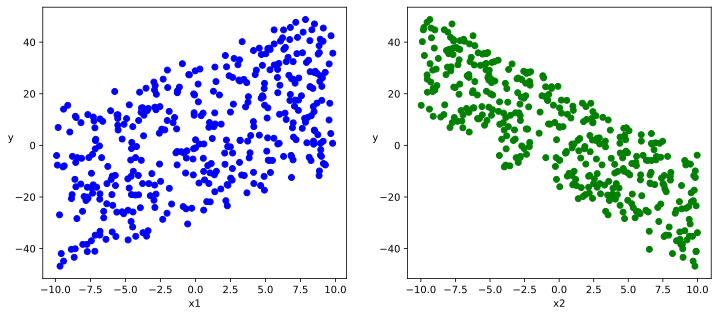

In [3]:
# 数据可视化

%matplotlib inline
%config InlineBackend.figure_format = 'svg'
plt.figure(figsize = (12,5))
ax1 = plt.subplot(121)
ax1.scatter(X[:,0],Y[:,0], c = "b")
plt.xlabel("x1")
plt.ylabel("y",rotation = 0)

ax2 = plt.subplot(122)
ax2.scatter(X[:,1],Y[:,0], c = "g")
plt.xlabel("x2")
plt.ylabel("y",rotation = 0)
plt.show()

### 2，定义模型

In [4]:
tf.keras.backend.clear_session()

model = models.Sequential()
model.add(layers.Dense(1, input_shape=(2,)))
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 1)                 3         
Total params: 3
Trainable params: 3
Non-trainable params: 0
_________________________________________________________________


### 3，训练模型

In [5]:
model.compile(optimizer='adam', loss='mse', metrics=["mae"])
model.fit(X, Y, batch_size=10, epochs=200)

tf.print("w =", model.layers[0].kernel)
tf.print("b =", model.layers[0].bias)

==============] - 0s 187us/sample - loss: 314.1643 - mae: 14.7998
Epoch 8/200
400/400 [==============================] - 0s 189us/sample - loss: 304.2457 - mae: 14.5721
Epoch 9/200
400/400 [==============================] - 0s 177us/sample - loss: 294.7088 - mae: 14.3475
Epoch 10/200
400/400 [==============================] - 0s 189us/sample - loss: 285.4312 - mae: 14.1228
Epoch 11/200
400/400 [==============================] - 0s 185us/sample - loss: 276.1986 - mae: 13.8971
Epoch 12/200
400/400 [==============================] - 0s 180us/sample - loss: 267.3905 - mae: 13.6774
Epoch 13/200
400/400 [==============================] - 0s 170us/sample - loss: 258.6971 - mae: 13.4585
Epoch 14/200
400/400 [==============================] - 0s 177us/sample - loss: 250.2922 - mae: 13.2469
Epoch 15/200
400/400 [==============================] - 0s 180us/sample - loss: 242.0368 - mae: 13.0282
Epoch 16/200
400/400 [==============================] - 0s 165us/sample - loss: 234.1206 - mae: 12.8151


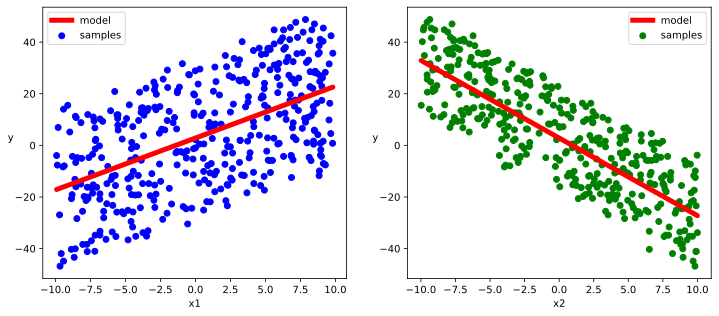

In [6]:

%matplotlib inline
%config InlineBackend.figure_format = 'svg'

w,b = model.variables

plt.figure(figsize = (12,5))
ax1 = plt.subplot(121)
ax1.scatter(X[:,0],Y[:,0], c = "b",label = "samples")
ax1.plot(X[:,0],w[0]*X[:,0]+b[0],"-r",linewidth = 5.0,label = "model")
ax1.legend()
plt.xlabel("x1")
plt.ylabel("y",rotation = 0)

ax2 = plt.subplot(122)
ax2.scatter(X[:,1],Y[:,0], c = "g",label = "samples")
ax2.plot(X[:,1],w[1]*X[:,1]+b[0],"-r",linewidth = 5.0,label = "model")
ax2.legend()
plt.xlabel("x2")
plt.ylabel("y",rotation = 0)

plt.show()

## 二，DNN而分类模型
### 1，准备数据

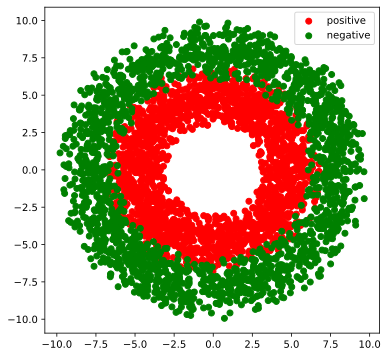

In [7]:
import numpy as np 
import pandas as pd 
from matplotlib import pyplot as plt
import tensorflow as tf
from tensorflow.keras import layers,losses,metrics,optimizers
%matplotlib inline
%config InlineBackend.figure_format = 'svg'

#正负样本数量
n_positive,n_negative = 2000,2000
n = n_positive+n_negative

#生成正样本, 小圆环分布
r_p = 5.0 + tf.random.truncated_normal([n_positive,1],0.0,1.0)
theta_p = tf.random.uniform([n_positive,1],0.0,2*np.pi) 
Xp = tf.concat([r_p*tf.cos(theta_p),r_p*tf.sin(theta_p)],axis = 1)
Yp = tf.ones_like(r_p)

#生成负样本, 大圆环分布
r_n = 8.0 + tf.random.truncated_normal([n_negative,1],0.0,1.0)
theta_n = tf.random.uniform([n_negative,1],0.0,2*np.pi) 
Xn = tf.concat([r_n*tf.cos(theta_n),r_n*tf.sin(theta_n)],axis = 1)
Yn = tf.zeros_like(r_n)

#汇总样本
X = tf.concat([Xp,Xn],axis = 0)
Y = tf.concat([Yp,Yn],axis = 0)

#样本洗牌
data = tf.concat([X,Y],axis = 1)
data = tf.random.shuffle(data)
X = data[:,:2]
Y = data[:,2:]


#可视化
plt.figure(figsize = (6,6))
plt.scatter(Xp[:,0].numpy(),Xp[:,1].numpy(),c = "r")
plt.scatter(Xn[:,0].numpy(),Xn[:,1].numpy(),c = "g")
plt.legend(["positive","negative"]);

In [11]:
ds_train = tf.data.Dataset.from_tensor_slices((X[0:n*3//4,:],Y[0:n*3//4,:])) \
     .shuffle(buffer_size = 1000).batch(20) \
     .prefetch(tf.data.experimental.AUTOTUNE) \
     .cache()

ds_valid = tf.data.Dataset.from_tensor_slices((X[n*3//4:,:],Y[n*3//4:,:])) \
     .batch(20) \
     .prefetch(tf.data.experimental.AUTOTUNE) \
     .cache()


### 2，定义模型

In [10]:
tf.keras.backend.clear_session()

class DNNModel(models.Model):
    def __init__(self):
        super(DNNModel, self).__init__()
    
    def build(self, input_shape):
        self.dense1 = layers.Dense(4, activation='relu')
        self.dense2 = layers.Dense(8, activation='relu')
        self.dense3 = layers.Dense(1, activation='sigmoid')
        super(DNNModel, self).build(input_shape)

    @tf.function
    def call(self, x):
        x = self.dense1(x)
        x = self.dense2(x)
        y = self.dense3(x)
        return y

model = DNNModel()
model.build(input_shape=(None, 2))
model.summary()

Model: "dnn_model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                multiple                  12        
_________________________________________________________________
dense_1 (Dense)              multiple                  40        
_________________________________________________________________
dense_2 (Dense)              multiple                  9         
Total params: 61
Trainable params: 61
Non-trainable params: 0
_________________________________________________________________


### 3，训练模型

In [15]:
optimizer = optimizers.Adam(learning_rate=0.01)
loss_func = losses.BinaryCrossentropy()

train_loss = tf.keras.metrics.Mean()
train_metric = tf.keras.metrics.BinaryAccuracy()

valid_loss = tf.keras.metrics.Mean()
valid_metric = tf.keras.metrics.BinaryAccuracy()

@tf.function
def train_step(model, features, labels):
    with tf.GradientTape() as tape:
        predictions = model(features)
        loss = loss_func(labels, predictions)
    grad = tape.gradient(loss, model.variables)
    optimizer.apply_gradients(zip(grad, model.variables))
    
    train_loss.update_state(loss)
    train_metric.update_state(labels, predictions)
    
@tf.function
def valid_step(model, feature, labels):
    predictions = model(features)
    batch_loss = loss_func(labels, predictions)
    valid_loss.update_state(batch_loss)
    valid_metric.update_state(labels, predictions)

def train_model(model, ds_train, ds_valid, epochs):
    for epoch in range(1, epochs+1):
        for features, labels in ds_train:
            train_step(model, features, labels)

        for features, labels in ds_valid:
            valid_step(model. features, labels)

        logs = 'Epoch={},Loss:{},Accuracy:{},Valid Loss:{},Valid Accuracy:{}'
        
        if  epoch%100 ==0:
            printbar()
            tf.print(tf.strings.format(logs,
            (epoch,train_loss.result(),train_metric.result(),valid_loss.result(),valid_metric.result())))

        train_loss.reset_states()
        valid_loss.reset_states()
        train_metric.reset_states()
        valid_metric.reset_states() 

train_model(model, ds_train, ds_valid, 1000)  

AttributeError: 'Adam' object has no attribute 'Adam'